# Sparsifying Convolutional Neural Network using RVSM


In [2]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
# tf.enable_eager_execution()
import numpy as np

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# Training Parameters
learning_rate = 0.001
# learning_rate = 0.00005
num_steps = 500
batch_size = 128
display_step = 50

In [4]:
# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
# X = tf.zeros([num_input,1])
# Y = tf.zeros([1,num_classes])
keep_prob = tf.constant(0.2) # dropout (keep probability)

In [5]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [6]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define hard thresholding parameters
lamb = 0.0005
beta = 0.1
gamma = lamb/beta

# Define loss and optimizers
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))

# AdamOptimizer

opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
grad = opt.compute_gradients(loss_op)   # grad is a list of tuples of the form (gradient, variable)
# grad[2] is the 3rd variable, which is the fully-connected layer we want to modify
w = grad[2][1]   # grad[2][1] is the weight w of the fc layer
condition = tf.greater(tf.abs(w), np.sqrt(2*gamma))
u = tf.where(condition, w, tf.zeros_like(w))   # u = threshold(w)
new_grad = grad[2][0] + beta * (w - u)   # replace the current gradient with \nabla_w Lagrangian
grad[2] = (new_grad, w)   # replace the 3rd tuple with (new gradient, w)
train_op1 = opt.apply_gradients(grad)   # feed new gradient to the Adam iteration

# Evaluate model

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
# A list of gradients is shown below, confirming that there should be 8 gradients: 4 weights and 4 biases
# This also confirms the 3rd tuple is the fc layer we want to modify

opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
opt.compute_gradients(loss_op)

[(<tf.Tensor 'gradients_1/Conv2D_grad/tuple/control_dependency_1:0' shape=(5, 5, 1, 32) dtype=float32>,
  <tf.Variable 'Variable:0' shape=(5, 5, 1, 32) dtype=float32_ref>),
 (<tf.Tensor 'gradients_1/Conv2D_1_grad/tuple/control_dependency_1:0' shape=(5, 5, 32, 64) dtype=float32>,
  <tf.Variable 'Variable_1:0' shape=(5, 5, 32, 64) dtype=float32_ref>),
 (<tf.Tensor 'gradients_1/MatMul_grad/tuple/control_dependency_1:0' shape=(3136, 1024) dtype=float32>,
  <tf.Variable 'Variable_2:0' shape=(3136, 1024) dtype=float32_ref>),
 (<tf.Tensor 'gradients_1/MatMul_1_grad/tuple/control_dependency_1:0' shape=(1024, 10) dtype=float32>,
  <tf.Variable 'Variable_3:0' shape=(1024, 10) dtype=float32_ref>),
 (<tf.Tensor 'gradients_1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(32,) dtype=float32>,
  <tf.Variable 'Variable_4:0' shape=(32,) dtype=float32_ref>),
 (<tf.Tensor 'gradients_1/BiasAdd_1_grad/tuple/control_dependency_1:0' shape=(64,) dtype=float32>,
  <tf.Variable 'Variable_5:0' shape=(64,) dty

In [9]:
# Initialize save function
saver = tf.train.Saver()

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [10]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op1, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 256 MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.0}))
    wbar = tf.Variable(w.eval())
    saver.save(sess, 'mnist1.chkp')


Step 1, Minibatch Loss= 50621.1602, Training Accuracy= 0.156
Step 50, Minibatch Loss= 3305.3025, Training Accuracy= 0.797
Step 100, Minibatch Loss= 2509.3518, Training Accuracy= 0.875
Step 150, Minibatch Loss= 1636.1376, Training Accuracy= 0.891
Step 200, Minibatch Loss= 2571.5571, Training Accuracy= 0.875
Step 250, Minibatch Loss= 1326.8799, Training Accuracy= 0.914
Step 300, Minibatch Loss= 641.3702, Training Accuracy= 0.961
Step 350, Minibatch Loss= 419.3207, Training Accuracy= 0.953
Step 400, Minibatch Loss= 795.2315, Training Accuracy= 0.922
Step 450, Minibatch Loss= 411.6193, Training Accuracy= 0.961
Step 500, Minibatch Loss= 311.4163, Training Accuracy= 0.961
Optimization Finished!
Testing Accuracy: 0.9609375


In [63]:
# Create two operations to evaluate the accuracy of the model. 
# The first one is when w is replaced with u = threshold(w).
# The second one is to make sure the code runs correctly. Here u is a reversed threshold of w where large values are pruned off.

# Evaluate with u

# condition = tf.greater(tf.abs(wbar), 16*np.sqrt(2*gamma))
# ubar = tf.where(condition, wbar, tf.zeros_like(wbar))   # This is threshold(wbar)
# # weights['wd1'] = ubar
# logits_u = conv_net(X, {
#                     'wc1': weights['wc1'],
#                     'wc2': weights['wc2'],
#                     'wd1': ubar,
#                     'out': weights['out']
#                     }, biases, keep_prob)
# prediction_u = tf.nn.softmax(logits_u)
# correct_pred_u = tf.equal(tf.argmax(prediction_u, 1), tf.argmax(Y, 1))
# accuracy_u = tf.reduce_mean(tf.cast(correct_pred_u, tf.float32))

def accuracy_u(wbar,conv_net,mult):
    condition = tf.greater(tf.abs(wbar), mult*np.sqrt(2*gamma))
    ubar = tf.where(condition, wbar, tf.zeros_like(wbar))   # This is threshold(wbar)
    # weights['wd1'] = ubar
    logits_u = conv_net(X, {
                        'wc1': weights['wc1'],
                        'wc2': weights['wc2'],
                        'wd1': ubar,
                        'out': weights['out']
                        }, biases, keep_prob)
    prediction_u = tf.nn.softmax(logits_u)
    correct_pred_u = tf.equal(tf.argmax(prediction_u, 1), tf.argmax(Y, 1))
    return [ubar, tf.reduce_mean(tf.cast(correct_pred_u, tf.float32))]

# Evaluate with not u

# condition = tf.greater(tf.abs(wbar), np.sqrt(2*gamma))
# unot = tf.where(condition, tf.zeros_like(wbar), wbar)   # This is a reversed threshold(wbar)
# weights['wd1'] = unot
# logits_unot = conv_net(X, weights, biases, keep_prob)
# prediction_unot = tf.nn.softmax(logits_unot)
# correct_pred_unot = tf.equal(tf.argmax(prediction_unot, 1), tf.argmax(Y, 1))
# accuracy_unot = tf.reduce_mean(tf.cast(correct_pred_unot, tf.float32))


init = tf.global_variables_initializer()

In [79]:
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, 'mnist1.chkp')
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    
    # Evaluate with w
    acc = sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.0})
    print('Total elements of w: {}'.format(size_w))
    print('Accuracy with w: {:.8}'.format(acc))    
    
    # Evaluate with u
    x=[]
    y=[]
    for j in range(2,21):
        mult = j/2
        [ubar, acc_u] = sess.run(accuracy_u(wbar,conv_net,mult), feed_dict={X: mnist.test.images[:256],
                                          Y: mnist.test.labels[:256],
                                          keep_prob: 1.0})
        size_w = 7*7*64*1024
        zeros_u = size_w - np.count_nonzero(ubar)
        sparse_u = zeros_u / size_w * 100
        print('Accuracy with u at {}x threshold: {:.8}'.format(mult, acc_u) + '. Sparsity: {:.2f}%'.format(sparse_u))
        x.append(sparse_u)
        y.append(acc_u)

INFO:tensorflow:Restoring parameters from mnist1.chkp
Total elements of w: 3211264
Accuracy with w: 0.9609375
Accuracy with u at 1.0x threshold: 0.9609375. Sparsity: 8.29%
Accuracy with u at 1.5x threshold: 0.96484375. Sparsity: 11.91%
Accuracy with u at 2.0x threshold: 0.96484375. Sparsity: 15.85%
Accuracy with u at 2.5x threshold: 0.9609375. Sparsity: 19.72%
Accuracy with u at 3.0x threshold: 0.9609375. Sparsity: 23.57%
Accuracy with u at 3.5x threshold: 0.94921875. Sparsity: 27.35%
Accuracy with u at 4.0x threshold: 0.953125. Sparsity: 31.08%
Accuracy with u at 4.5x threshold: 0.9453125. Sparsity: 34.73%
Accuracy with u at 5.0x threshold: 0.9453125. Sparsity: 38.29%
Accuracy with u at 5.5x threshold: 0.9296875. Sparsity: 41.77%
Accuracy with u at 6.0x threshold: 0.94140625. Sparsity: 45.16%
Accuracy with u at 6.5x threshold: 0.93359375. Sparsity: 48.43%
Accuracy with u at 7.0x threshold: 0.94921875. Sparsity: 51.61%
Accuracy with u at 7.5x threshold: 0.94140625. Sparsity: 54.68%
Acc

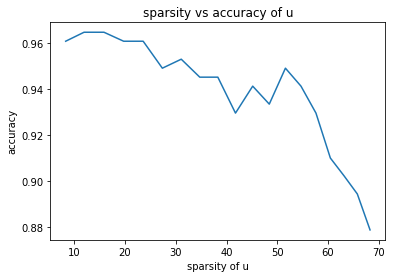

In [84]:
plt.xlabel('sparsity of u')
plt.ylabel('accuracy')
plt.title('sparsity vs accuracy of u')
plt.plot(x,y)
plt.show()